<a href="https://colab.research.google.com/github/Acheon-stst/Acheon-stst/blob/main/DNSC3288.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

MIT License

Copyright (c) 2025 Andrew Cheon

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.




# Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance

from itertools import product


In [10]:
# Check model version
print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Scikit-learn:", sklearn.__version__)
print("XGBoost:", xgboost.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
XGBoost: 3.1.2


# Load Datasets


In [7]:
# Load the main training set (daily sales)
sales = pd.read_csv("sales_train.csv")

# Kaggle test set
test  = pd.read_csv("test.csv")

# Metadata files
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
cats  = pd.read_csv("item_categories.csv")



# Data Analysis

In [8]:
# Provide (rows, columns)
# Before monthly aggregation
sales.shape


(2935849, 6)

In [11]:
# Provide (rows, columns) of test dataset
test.shape

(214200, 3)

In [12]:
# column names
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [13]:
sales.isnull().any()


,0
date,False
date_block_num,False
shop_id,False
item_id,False
item_price,False
item_cnt_day,False


In [14]:
sales.describe()


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


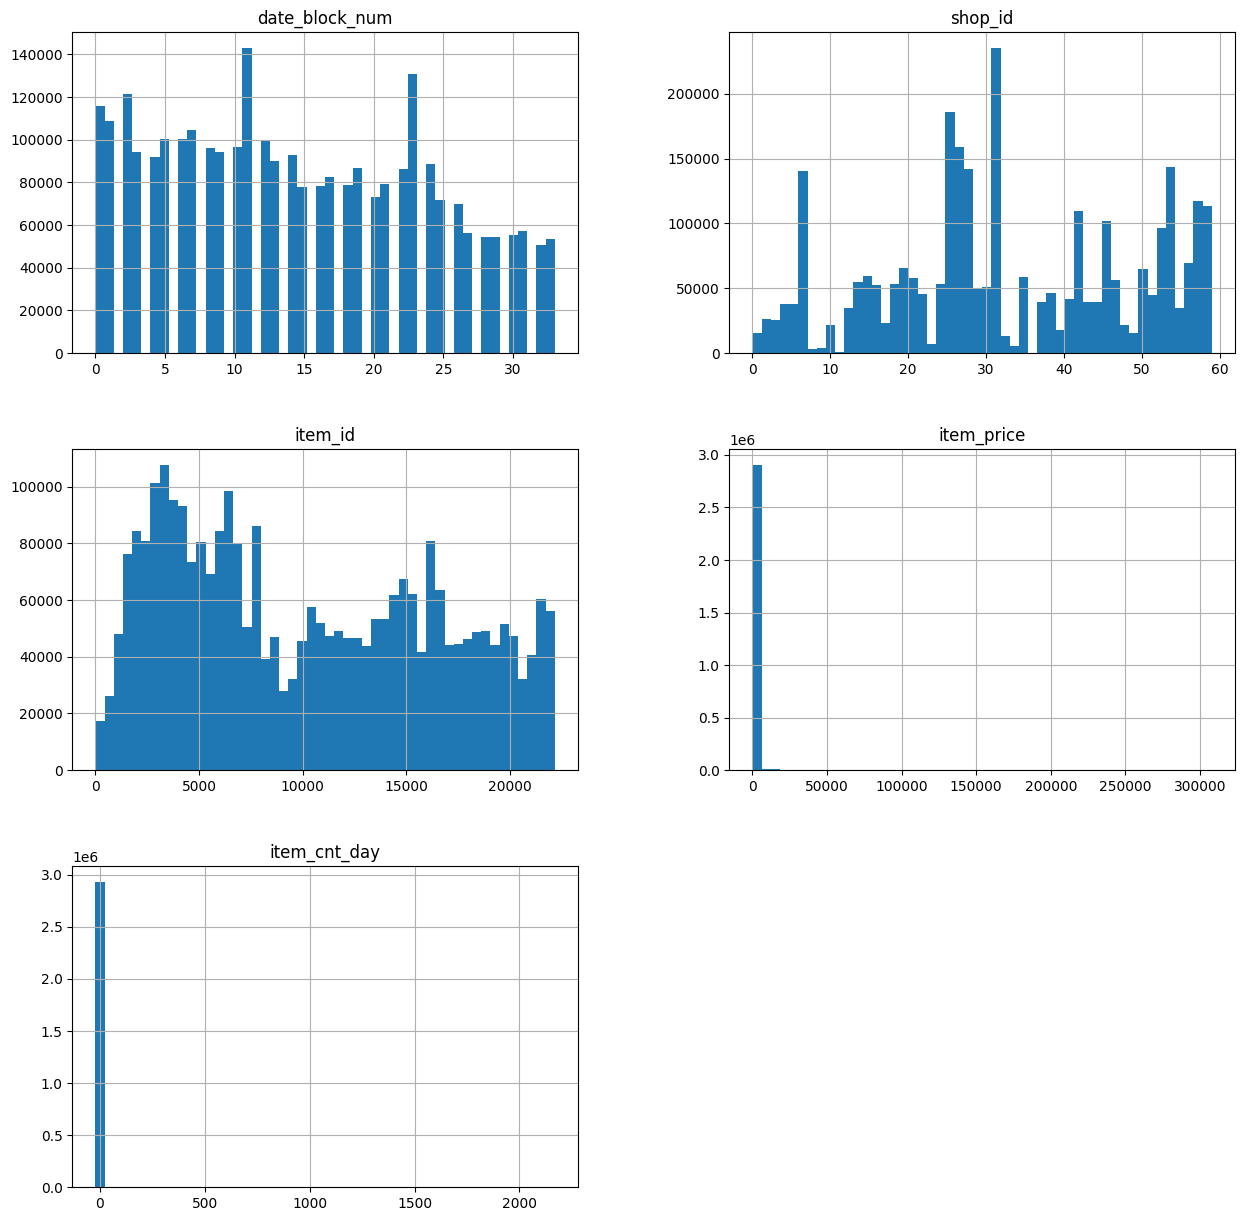

In [15]:
histogram = sales.hist(bins=50, figsize=(15, 15))


 # Cleaning & Preprocessing the raw sales data

In [16]:
# Kaggle metric clips predictions to [0,20]
sales["item_cnt_day"] = sales["item_cnt_day"].clip(0, 20)

# Convert daily data → monthly data since Kaggle expects monthly prediction, not daily
# Aggregate total sales per (month, shop, item)
monthly = (
    sales.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
         .agg({"item_cnt_day": "sum",
               "item_price": "mean"})
)

# Renaming item_cnt_day to item_cnt_month
monthly.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

# Add item_category_id
monthly = monthly.merge(items[["item_id", "item_category_id"]],
                        on="item_id", how="left")





In [17]:
full_matrix = monthly.copy()

In [18]:
# Item mean sales across all history
item_mean_all = full_matrix.groupby("item_id")["item_cnt_month"].mean().reset_index()
item_mean_all.rename(columns={"item_cnt_month": "item_mean_all"}, inplace=True)
full_matrix = full_matrix.merge(item_mean_all, on="item_id", how="left")

# Shop mean sales
shop_mean_all = full_matrix.groupby("shop_id")["item_cnt_month"].mean().reset_index()
shop_mean_all.rename(columns={"item_cnt_month": "shop_mean_all"}, inplace=True)
full_matrix = full_matrix.merge(shop_mean_all, on="shop_id", how="left")

# Category mean
cat_mean_all = full_matrix.groupby("item_category_id")["item_cnt_month"].mean().reset_index()
cat_mean_all.rename(columns={"item_cnt_month": "cat_mean_all"}, inplace=True)
full_matrix = full_matrix.merge(cat_mean_all, on="item_category_id", how="left")


# Creating a full shop-item-month matrix


In [19]:
# Missing combinations must be filled → assume 0 sales
# List unique shops, items, and months
train_matrix = monthly[["date_block_num", "shop_id", "item_id"]].copy()

# Add test rows (month 34)
test["date_block_num"] = 34
test_matrix = test[["date_block_num", "shop_id", "item_id"]].copy()

full_matrix = pd.concat([train_matrix, test_matrix], ignore_index=True).drop_duplicates()

# Merge true monthly sales
full_matrix = full_matrix.merge(
    monthly,
    on=["date_block_num", "shop_id", "item_id"],
    how="left"
)

# Missing sales → 0
full_matrix["item_cnt_month"] = full_matrix["item_cnt_month"].fillna(0)

# Add category
full_matrix = full_matrix.merge(items[["item_id", "item_category_id"]],
                                on="item_id", how="left")


print(full_matrix.shape)


(1823324, 7)


In [20]:
full_matrix.columns

# Handle Duplicate category columns
if "item_category_id_x" in full_matrix.columns:
    full_matrix["item_category_id"] = full_matrix["item_category_id_x"]
    full_matrix.drop(["item_category_id_x", "item_category_id_y"], axis=1, inplace=True)


full_matrix.columns


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'item_category_id'],
      dtype='object')

In [21]:
# Generate lag features
# Use past sales to predict future sales
def create_lag(df, col, lags):
    """Create lag features for grouped shop-item sequences."""
    for lag in lags:
        df[f"{col}_lag_{lag}"] = df.groupby(["shop_id", "item_id"])[col].shift(lag)
    return df





In [22]:
# Lags of sales
full_matrix = create_lag(full_matrix, "item_cnt_month", [1, 2, 3, 6, 12])

# Shop avg sales
shop_avg = full_matrix.groupby(["date_block_num", "shop_id"])["item_cnt_month"].mean().reset_index()
shop_avg.rename(columns={"item_cnt_month": "shop_avg_sales"}, inplace=True)
full_matrix = full_matrix.merge(shop_avg, on=["date_block_num", "shop_id"], how="left")
full_matrix = create_lag(full_matrix, "shop_avg_sales", [1])






In [23]:
# Item avg sales
item_avg = full_matrix.groupby(["date_block_num", "item_id"])["item_cnt_month"].mean().reset_index()
item_avg.rename(columns={"item_cnt_month": "item_avg_sales"}, inplace=True)
full_matrix = full_matrix.merge(item_avg, on=["date_block_num", "item_id"], how="left")
full_matrix = create_lag(full_matrix, "item_avg_sales", [1])

In [24]:
# Category avg sales
cat_avg = full_matrix.groupby(["date_block_num", "item_category_id"])["item_cnt_month"].mean().reset_index()
cat_avg.rename(columns={"item_cnt_month": "category_avg_sales"}, inplace=True)
full_matrix = full_matrix.merge(cat_avg, on=["date_block_num", "item_category_id"], how="left")
full_matrix = create_lag(full_matrix, "category_avg_sales", [1])

# Correlation Heatmap Analysis

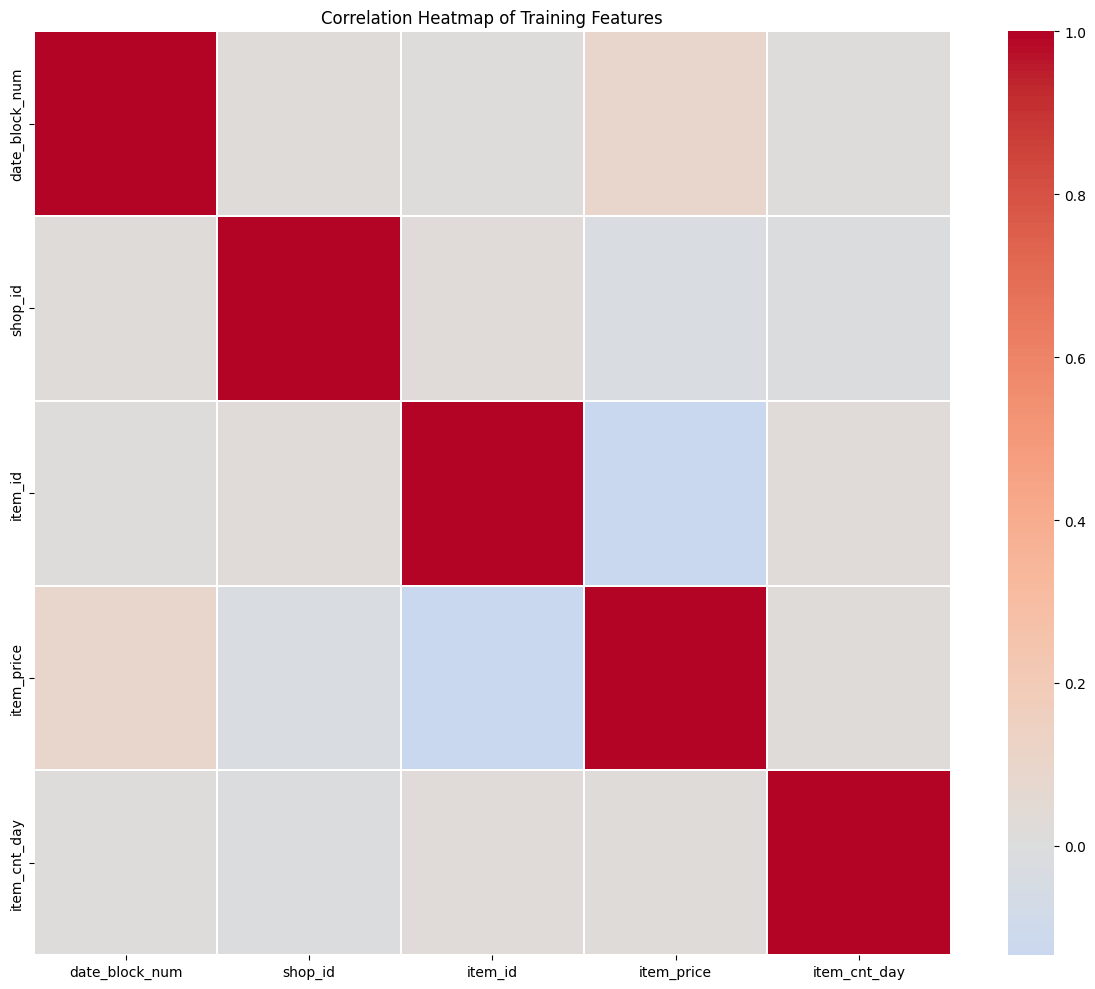

In [42]:
# Select numeric columns from Sales_train.csv
sales_cols = sales.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = sales_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.1
)

plt.title("Correlation Heatmap of Training Features")
plt.tight_layout()
plt.savefig("correlation_heatmap0.png")
plt.show()

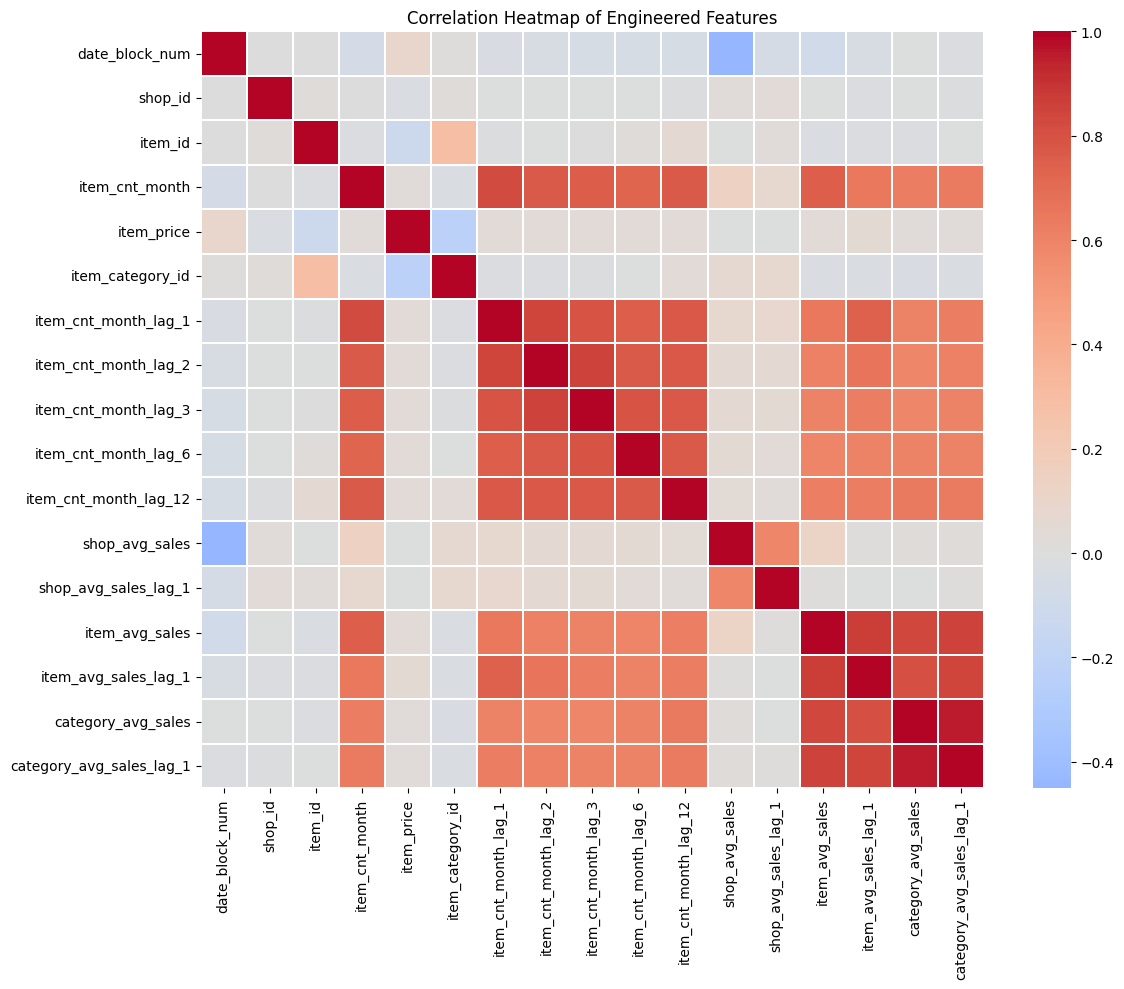

In [41]:
# Select numeric columns from the training matrix created
numeric_cols = full_matrix.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = numeric_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.1
)

plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

# XGBoost Feature Importance

<Figure size 1000x800 with 0 Axes>

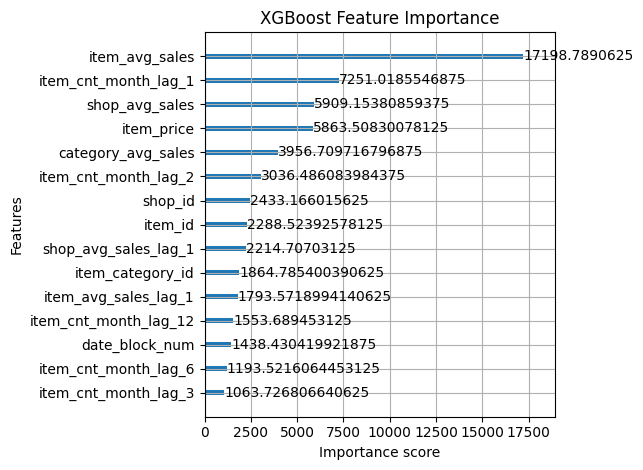

In [45]:
# Create a plot
plt.figure(figsize=(10, 8))
plot_importance(
    model,
    max_num_features=15,
    importance_type="gain"
)

plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


# Train–Validation Split

In [25]:
# Use month 33 (Oct 2015) as validation
# Month 33 simulates “future unseen data”
train = full_matrix[full_matrix["date_block_num"] < 33]
val   = full_matrix[full_matrix["date_block_num"] == 33]

# Feature selection
FEATURES = [
    c for c in full_matrix.columns
    if c not in ["item_cnt_month", "item_price_avg"]
]

X_train, y_train = train[FEATURES], train["item_cnt_month"]
X_val, y_val     = val[FEATURES],   val["item_cnt_month"]

print("Training rows:", X_train.shape, "Validation rows:", X_val.shape)


Training rows: (1577593, 16) Validation rows: (31531, 16)


# Train XGBoost Model


In [26]:
model = XGBRegressor(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

print("Training model")
model.fit(X_train, y_train)




Training model


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

# Training Data Evaluation

In [47]:
train_pred = model.predict(X_train)
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
print("Train RMSE:", train_rmse)

Train RMSE: 1.4353679020038657


# Validation Evaluation

In [50]:
val_pred = model.predict(X_val)
rmse = sqrt(mean_squared_error(y_val, val_pred))
print("Validation RMSE:", rmse)

Validation RMSE: 2.205896931447286


# Preparing Test Dataset

In [28]:
for col in ["item_category_id", "item_category_id_x", "item_category_id_y"]:
    if col in test.columns:
        test.drop(col, axis=1, inplace=True)

# Rebuild clean category column
test = test.merge(
    items[["item_id", "item_category_id"]],
    on="item_id",
    how="left"
)


# Restore date_block_num
test["date_block_num"] = 34

# Pull last-month features
last_month_features = full_matrix[full_matrix["date_block_num"] == 33][FEATURES].drop_duplicates()

# Merge engineered features into test
test_ff = test.merge(
    last_month_features,
    on=["shop_id", "item_id", "item_category_id"],
    how="left"
)

# Restore date_block_num again
test_ff["date_block_num"] = 34

test_ff.fillna(0, inplace=True)

X_test = test_ff[FEATURES]


test_pred = np.clip(model.predict(X_test), 0, 20)


# Submission

In [29]:
submission = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": test_pred
})

submission.to_csv("Group8_submission.csv", index=False)

submission

,ID,item_cnt_month
0,0,0.714192
1,1,0.841948
2,2,1.362786
3,3,0.713629
4,4,0.714192
...,...,...
214195,214195,1.032882
214196,214196,0.647461
214197,214197,0.666214
214198,214198,0.623798
